In [ ]:
suppressPackageStartupMessages(library(cicero))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(tidyr))

clus <- makeCluster(32)

wd = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/run_cicero_paola/'
setwd(wd)
args<-commandArgs(TRUE)

input_mat  = args[1]
out_prefix = args[2]
subsamp    = args[3]

data    = read.table( input_mat ,header=T,  sep="\t")


sc.umap = read.table( "../peaks/pbmc1-15_clusterLabels.txt", header=T, row.names=1,  sep="\t") ### map barcode to cluster 
rownames(sc.umap) = sc.umap$X

#sc.umap = read.table( "../peaks/old_labels", row.names=1,  sep="\t")
#colnames(sc.umap) = c('UMAP1','UMAP2', 'leiden', 'cell')


if(subsamp=='yes'){
### subset to only the older set of pbmcs
sc.umap = droplevels(subset(sc.umap, !(sample %in% c( 'pbmc13', 'pbmc14', 'pbmc15'))))
data    = droplevels(subset(data, barcode %in% rownames(sc.umap)))
} else{
   sc.umap = sc.umap
    data   = data
}


### convert to sparse matrix peak x barcode
sc.data <- with(data, sparseMatrix(i=as.numeric(as.factor(peak)), j=as.numeric(as.factor(barcode)), 
                                   x=value, dimnames=list(levels(as.factor(peak)), levels(as.factor(barcode)))))
rownames(sc.data) <- paste0('chr', gsub('-','_', gsub(':','_',rownames(sc.data))))


sc.data.subset <- sc.data


cellinfo <-data.frame(cells=colnames(sc.data.subset))
row.names(cellinfo) <- cellinfo$cells
dhsinfo <- data.frame(site_name=rownames(sc.data.subset))
row.names(dhsinfo) <- dhsinfo$site_name
dhsinfo <- cbind(dhsinfo, stringr::str_split_fixed(dhsinfo$site_name, "_", 3))
names(dhsinfo) <- c('site_name','chr','bp1','bp2')
dhsinfo$chr <- gsub('chr','', dhsinfo$chr)
dhsinfo$bp1 <- as.numeric(as.character(dhsinfo$bp1))
dhsinfo$bp2 <- as.numeric(as.character(dhsinfo$bp2))

input_cds <- suppressWarnings(newCellDataSet(as(sc.data.subset, 'dgCMatrix'),
                                             phenoData = methods::new('AnnotatedDataFrame', data = cellinfo),
                                             featureData = methods::new('AnnotatedDataFrame', data = dhsinfo),
                                             expressionFamily=negbinomial.size(),
                                             lowerDetectionLimit=0))
input_cds@expressionFamily <- binomialff()
input_cds@expressionFamily@vfamily <- 'binomialff'
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)

input_cds <- input_cds[fData(input_cds)$num_cells_expressed > 0,]
umap_coords <- sc.umap[colnames(sc.data.subset), c('UMAP1','UMAP2')]
colnames(umap_coords) <- NULL

cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords, k=30)
window <- 1e6
data('human.hg19.genome')
distance_parameters <- estimate_distance_parameter(cicero_cds, window=window, maxit=100, sample_num=100, distance_constraint=500000, genomic_coords=human.hg19.genome)
mean_distance_parameter <- mean(unlist(distance_parameters))
cicero_out <- generate_cicero_models(cicero_cds, distance_parameter=mean_distance_parameter, window=window, genomic_coords=human.hg19.genome)
conns <- assemble_connections(cicero_out, silent=FALSE)
#saveRDS(conns, file.path(wd, paste0('cicero/', cluster, '.1MB_cicero_conns.rds')))
#write.table(conns, file.path(wd, paste0('output/', celltype, '.cicero_conns_dedup.txt')), sep='\t', quote=FALSE, row.names=FALSE)

## this step is to remove duplicated connections
conns = conns[order(-conns$coaccess),]
bed = cbind(str_split_fixed(conns[,1], "\\_", 3 ), str_split_fixed(conns[,2], "\\_", 3 ))

ord = matrix(parRapply(clus, bed, function(x) x[order(as.numeric(x))] ), ncol=6, byrow=T)

ord = cbind(ord[, c(5,1:2,5,3:4)], conns$coaccess)
dedup = ord[!duplicated(ord[,1:6]),]                      

dist = as.numeric(dedup[,6])-as.numeric(dedup[,2])
dedup  = subset(dedup, dist >10000)
                       
dedup = data.frame( Peak1 = paste(dedup[,1], dedup[,2], dedup[,3], sep="_")  , 
                    Peak2 = paste(dedup[,4], dedup[,5], dedup[,6], sep="_") , coaccess = dedup[,7]  )


write.table(dedup, file.path(wd, paste0('output/', out_prefix, '.cicero_conns_dedup.txt')), sep='\t', quote=FALSE, row.names=FALSE)



writeLines(c("tot_pairs", nrow(dedup),"coaccess", sum(as.numeric(dedup[,3])>0.05, na.rm=T))
           , paste0('output/', out_prefix,"summary"))

### Compare with PCHiC

In [16]:
setwd(file.path(wd, 'output'))

In [ ]:
#### Promoter Cature HiC Primary cells
dir = "/nfs/lab/projects/pbmc_snATAC/data/publicdata/"
pc = read.table(paste0( dir, 'PCHiC_peak_matrix_cutoff5.tsv'), header=T)

cells = colnames(pc)[14:ncol(pc)-2]
wcel = data.frame(Peak1 = paste0("chr", pc$baitChr,"_" , pc$baitStart, "_" , pc$baitEnd),
                  Peak2 = paste0("chr", pc$oeChr,"_" , pc$oeStart, "_" , pc$oeEnd),
                 pc[,cells],
                 dist = abs(pc$dist))
wcel = subset(wcel, dist <  1050000)
wcel = subset(wcel, dist >  10000)


In [ ]:
load_filtered_connections = function( cluster) {

infile   = paste0( cluster,   '.cicero_conns_dedup.txt')
outfile  = paste0(cluster, '.cicero_conns_dedup.bedpe')
baits    = '/nfs/lab/projects/pbmc_snATAC/data/publicdata/Digest_Human_HindIII_baits.bed'
filtfile = paste0(cluster, '.cicero_conns_baits')

    if(!file.exists(filtfile)){
#sed = paste("tail -n +2", infile, "| sed 's/_/\\t/g' | pgltools sort >" , outfile) ## double escape
#sed = paste( "sed 's/_/\\t/g'", infile, "| pgltools sort >" , outfile) ## double escape
sed = paste("awk -F \"\\t\" '{print $1,$2,$3}'", infile, "| tail -n +2 | sed 's/_/\\t/g' | pgltools sort >" , outfile) 
        
pgl = paste('pgltools intersect1D -a', outfile ,'-b' , baits,  '-wa -d 1000 >', filtfile)

system(sed)
system(pgl)
}
conns = fread(filtfile, data.table=F, header=F, sep="\t")
conns = conns[!duplicated(conns[,1:6]),]
    
cic = data.frame(Peak1 = paste(conns[,1], conns[,2], conns[,3], sep="_"), 
                 Peak2 = paste(conns[,4], conns[,5], conns[,6], sep="_"), coaccess = conns[,8])
cic$dist = conns[,6]- conns[,2]
return(cic)
}


In [ ]:

cic = load_filtered_connections( cluster=out_prefix )
cic = subset(cic, dist>10000)

cic$signif <- cic$coaccess > 0.05 

test = matrix(unlist(mclapply(cells, function(x) compare_connections(cic, data.frame(wcel[wcel[,x]>=5,1:2]), maxgap=1000),
                  mc.cores =18)), ncol=length(cells))
colnames(test) = cells   
    
tab = matrix(unlist(mclapply(cells, function(x)fisher.test(rbind(table(test[cic$signif==FALSE, x]), 
                                              table(test[cic$signif, x])))[c("p.value", "estimate")] )), nrow=2)
colnames(tab)=cells
rownames(tab) = c("pv.pos", "or.pos")
write.table (tab, paste0(out_prefix, ".comparePCHIC.fisher"),  sep="\t", quote=F)


                             

### Plot results

In [30]:
library(pheatmap)
library(RColorBrewer)

In [17]:
setwd(file.path(wd, 'output'))

In [ ]:
clusters_selection = c('b.1to12' , 'nk.1to12', 't.1to12', 'mono.1to12')

In [44]:
clusters_selection = c('b.full' , 'nk.full', 't.full', 'mono.full', "Bcell_old")

In [45]:
ORp = data.frame()
for (c in clusters_selection){
    fi = t(read.table( paste0( c, ".comparePCHIC.fisher"), row.names=1, header=T))
    ORp = rbind(ORp, fi[,"or.pos"])
    }


colnames(ORp) = rownames(fi)
rownames(ORp) =  clusters_selection



pheatmap(ORp[,-9], cellheight = 12, cellwidth  = 12, angle_col = 90,
         filename="Fisher_heatmap_full_nofetal.pdf",
         color = colorRampPalette( brewer.pal(9, "YlOrRd"))(20))


In [48]:
smr = data.frame()
for (c in clusters_selection){
   
    smr = rbind(smr, as.numeric(readLines(paste0( c, "summary"))[c(2,4)]))
}

In [49]:
rownames(smr)= clusters_selection
colnames(smr)=c("tested", 'coaccess')

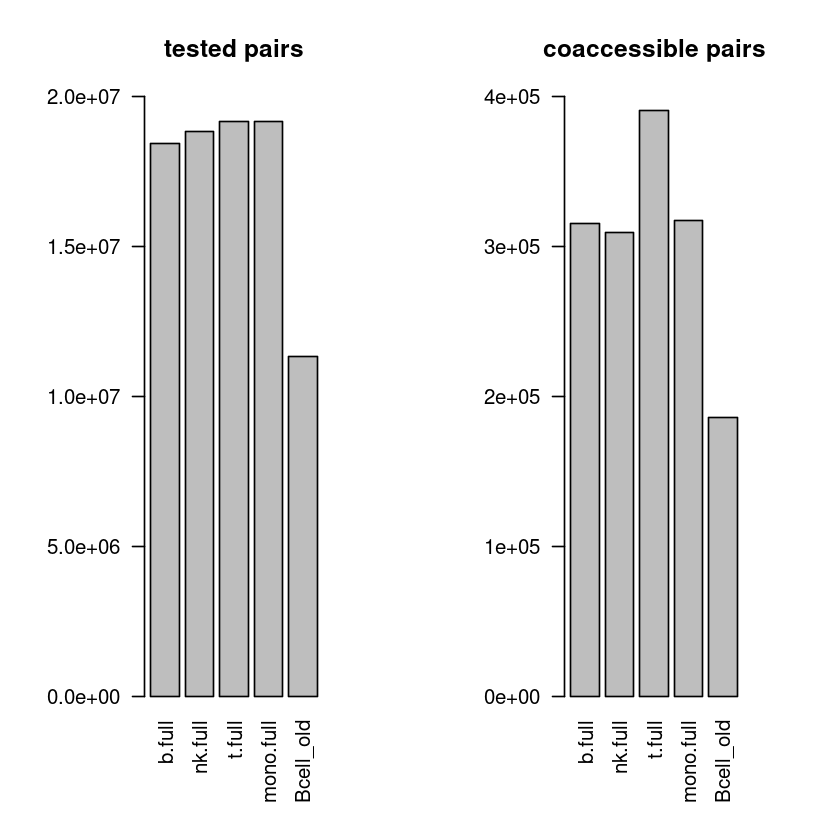

In [50]:
par(mfrow=c(1,2), las=2, mar = c(6,6,4,4))
barplot(smr[,1], main = "tested pairs", names = rownames(smr), ylim=c(0,2e+7))
barplot(smr[,2], main = "coaccessible pairs",names = rownames(smr),ylim=c(0,4e+5))

### Plot_results per sample